In [1]:
import sys  
#sys.executable} -m pip install pandas
import pandas as pd
import numpy as np

#!{sys.executable} -m pip install geopandas
import geopandas as gpd


import warnings
warnings.filterwarnings('ignore')

#!{sys.executable} -m pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt

#!{sys.executable} -m pip install folium
import folium
#!{sys.executable} -m pip install geopy

import geopy.distance
import glob

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


##### IPUMS  (Census Source) :  https://data2.nhgis.org/main

#### US Census (Location Coordinates): https://www.census.gov/cgi-bin/geo/shapefiles/index.php

In [2]:
# loading the data file pulled from IPUMS website
df=pd.read_csv('nhgis0018_csv/nhgis0018_ds249_20205_blck_grp.csv')

In [3]:
df.shape

(98220, 531)

In [24]:
df.STATE.unique()

array(['California', 'Connecticut', 'Florida', 'Georgia', 'Mississippi',
       'New Jersey', 'New York', 'Texas', 'Washington'], dtype=object)

In [4]:
df[df.columns[:15]].head()

,GISJOIN,YEAR,STUSAB,REGIONA,DIVISIONA,STATE,STATEA,COUNTY,COUNTYA,CTY_SUBA,PLACEA,TRACTA,BLCK_GRPA,C_CITYA,AIANHHA
0,G06000104001001,2016-2020,CA,NaN,NaN,California,6,Alameda County,1,NaN,NaN,400100,1,NaN,NaN
1,G06000104001002,2016-2020,CA,NaN,NaN,California,6,Alameda County,1,NaN,NaN,400100,2,NaN,NaN
2,G06000104002001,2016-2020,CA,NaN,NaN,California,6,Alameda County,1,NaN,NaN,400200,1,NaN,NaN
3,G06000104002002,2016-2020,CA,NaN,NaN,California,6,Alameda County,1,NaN,NaN,400200,2,NaN,NaN
4,G06000104003001,2016-2020,CA,NaN,NaN,California,6,Alameda County,1,NaN,NaN,400300,1,NaN,NaN


In [5]:
location_cols = ['GISJOIN','STATE','STATEA','COUNTY','COUNTYA','TRACTA','BLCK_GRPA']

In [6]:
# renaming the columns with the names present in the data documentaion file
columns = {
'AMPVE001':    'Total_Population',
'AMQHE001':    'Total_Working',
'AMQHE002':    'Less than 10 minutes',
'AMQHE003':    '10 to 14 minutes',
'AMQHE004':    '15 to 19 minutes',
'AMQHE005':    '20 to 24 minutes',
'AMQHE006':    '25 to 29 minutes',
'AMQHE007':    '30 to 34 minutes',
'AMQHE008':    '35 to 44 minutes',
'AMQHE009':    '45 to 59 minutes',
'AMQHE010':    '60 or more minutes',
'AMQKE002':    'Car, truck, or van',
'AMQKE003':    'Car, truck, or van: Drove alone',
'AMQKE016':    'Taxicab',
'AMQKE017':    'Motorcycle',
'AMQKE018':    'Bicycle',
'AMQKE019':    'Walked',
'AMQKE020':    'Other means of transport',
'AMQKE021':    'Worked from home',
'AMR7E002':    'Less than $10,000',
'AMR7E003':    '$10,000 to $14,999',
'AMR7E004':    '$15,000 to $19,999',
'AMR7E005':    '$20,000 to $24,999',
'AMR7E006':    '$25,000 to $29,999',
'AMR7E007':    '$30,000 to $34,999',
'AMR7E008':    '$35,000 to $39,999',
'AMR7E009':    '$40,000 to $44,999',
'AMR7E010':    '$45,000 to $49,999',
'AMR7E011':    '$50,000 to $59,999',
'AMR7E012':    '$60,000 to $74,999',
'AMR7E013':    '$75,000 to $99,999',
'AMR7E014':    '$100,000 to $124,999',
'AMR7E015':    '$125,000 to $149,999',
'AMR7E016':    '$150,000 to $199,999',
'AMR7E017':    '$200,000 or more',
'AMT9E002':    'In labor force',
'AMT9E003':    'In labor force: Civilian labor force',
'AMT9E004':    'In labor force: Civilian labor force: Employed',
'AMT9E005':    'In labor force: Civilian labor force: Unemployed',
'AMT9E006':    'In labor force: Armed Forces',
'AMT9E007':   'Not in labor force'
    }
    
df = df.rename(columns=columns)

In [7]:
# taking only selected column groups
int_cols = location_cols + list(columns.values())
print(df[int_cols].shape)
df= df[int_cols]
df.head()

(98220, 48)


,GISJOIN,STATE,STATEA,COUNTY,COUNTYA,TRACTA,BLCK_GRPA,Total_Population,Total_Working,Less than 10 minutes,...,"$100,000 to $124,999","$125,000 to $149,999","$150,000 to $199,999","$200,000 or more",In labor force,In labor force: Civilian labor force,In labor force: Civilian labor force: Employed,In labor force: Civilian labor force: Unemployed,In labor force: Armed Forces,Not in labor force
0,G06000104001001,California,6,Alameda County,1,400100,1,1713,682,58,...,67,38,35,330,870,870,854,16,0,476
1,G06000104001002,California,6,Alameda County,1,400100,2,1322,503,84,...,25,54,47,394,717,717,717,0,0,448
2,G06000104002001,California,6,Alameda County,1,400200,1,940,400,0,...,41,6,68,243,544,544,521,23,0,214
3,G06000104002002,California,6,Alameda County,1,400200,2,1043,478,24,...,44,38,54,173,690,690,615,75,0,221
4,G06000104003001,California,6,Alameda County,1,400300,1,1206,687,27,...,6,0,71,250,797,797,782,15,0,130


In [8]:
# feature engineering from existing features

df['travel_time_<30mins'] =df[['Less than 10 minutes', '10 to 14 minutes', '15 to 19 minutes','20 to 24 minutes', '25 to 29 minutes']].sum(axis=1)
df['travel_time_30_to_60_mins'] =df[['30 to 34 minutes','35 to 44 minutes', '45 to 59 minutes']].sum(axis=1)
df.rename(columns={'60 or more minutes':'travel_time_>60_mins'},inplace=True)


df['income_group_$10k_to_$25k'] = df[['$10,000 to $14,999', '$15,000 to $19,999', '$20,000 to $24,999']].sum(axis=1)
df['income_group_$25k_to_$50k'] = df[['$25,000 to $29,999','$30,000 to $34,999', '$35,000 to $39,999', '$40,000 to $44,999','$45,000 to $49,999']].sum(axis=1)
df['income_group_$50k_to_$100k'] = df[['$50,000 to $59,999', '$60,000 to $74,999','$75,000 to $99,999']].sum(axis=1)
df['income_group_$100k_to_$200k'] = df[['$100,000 to $124,999', '$125,000 to $149,999','$150,000 to $199,999']].sum(axis=1)
df.rename(columns={'Less than $10,000':'income_group_<$10k','$200,000 or more':'income_group_>$200k'},inplace=True)



In [9]:
new_mod_cols = ['travel_time_<30mins','travel_time_30_to_60_mins','travel_time_>60_mins',
            'income_group_<$10k','income_group_$10k_to_$25k','income_group_$25k_to_$50k', 
            'income_group_$50k_to_$100k','income_group_$100k_to_$200k','income_group_>$200k']

In [10]:
other_cols=['Total_Population', 'Total_Working','Car, truck, or van','Taxicab','Motorcycle','Bicycle','Walked','Other means of transport','Worked from home',
'In labor force','In labor force: Civilian labor force','In labor force: Civilian labor force: Employed','In labor force: Civilian labor force: Unemployed','In labor force: Armed Forces','Not in labor force']

In [11]:
new_all_col=location_cols+new_mod_cols+other_cols

In [12]:
# subsetting with new column names
df_mod = df[new_all_col]

### Shape files

In [13]:
int('00100')

100

In [14]:
36
100
101
01

GEOID : 3610010101
GISJOIN : 36001000010101

SyntaxError: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (1769400016.py, line 4)

In [15]:
GISJOIN ID 

SyntaxError: invalid syntax (3904730993.py, line 1)

In [16]:
GEOID 

NameError: name 'GEOID' is not defined

In [17]:
# loading the shape file pulled from US Census website
# getting the file names

shape_files = glob.glob('shape_files/tl_*bg/*.shp')
print(len(shape_files))
shape_list = []
for file in shape_files:
    sp_df = gpd.read_file(file)
    shape_list.append(sp_df)

# appending loaded shape files
shape_df=pd.concat(shape_list)
shape_df.shape

9


(98220, 13)

In [18]:
shape_df['COUNTYFP'].head()

0    001
1    001
2    001
3    001
4    013
Name: COUNTYFP, dtype: object

In [19]:
shape_df['COUNTYFP'].apply(int).apply(str).head()

0     1
1     1
2     1
3     1
4    13
Name: COUNTYFP, dtype: object

In [21]:
df.head()

,GISJOIN,STATE,STATEA,COUNTY,COUNTYA,TRACTA,BLCK_GRPA,Total_Population,Total_Working,Less than 10 minutes,...,In labor force: Civilian labor force: Employed,In labor force: Civilian labor force: Unemployed,In labor force: Armed Forces,Not in labor force,travel_time_<30mins,travel_time_30_to_60_mins,income_group_$10k_to_$25k,income_group_$25k_to_$50k,income_group_$50k_to_$100k,income_group_$100k_to_$200k
0,G06000104001001,California,6,Alameda County,1,400100,1,1713,682,58,...,854,16,0,476,359,231,65,22,77,140
1,G06000104001002,California,6,Alameda County,1,400100,2,1322,503,84,...,717,0,0,448,284,148,12,22,39,126
2,G06000104002001,California,6,Alameda County,1,400200,1,940,400,0,...,521,23,0,214,138,238,6,16,37,115
3,G06000104002002,California,6,Alameda County,1,400200,2,1043,478,24,...,615,75,0,221,214,191,5,23,76,136
4,G06000104003001,California,6,Alameda County,1,400300,1,1206,687,27,...,782,15,0,130,254,411,0,51,45,77


In [20]:
shape_df.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,34,001,012502,2,340010125022,Block Group 2,G5030,S,1241976,105122,+39.3440481,-074.5835582,"POLYGON ((-74.59606 39.33743, -74.59594 39.337..."
1,34,001,012602,1,340010126021,Block Group 1,G5030,S,2863331,159099,+39.3267130,-074.5714906,"POLYGON ((-74.58663 39.32983, -74.58638 39.330..."
2,34,001,012701,1,340010127011,Block Group 1,G5030,S,839903,0,+39.3264957,-074.6017962,"POLYGON ((-74.61021 39.32302, -74.60966 39.323..."
3,34,001,012701,2,340010127012,Block Group 2,G5030,S,1011392,181409,+39.3303157,-074.6165530,"POLYGON ((-74.62210 39.33052, -74.62207 39.330..."
4,34,013,021802,3,340130218023,Block Group 3,G5030,S,2685796,7052,+40.8614395,-074.2949349,"POLYGON ((-74.31306 40.85643, -74.31181 40.857..."


In [23]:
'100'+'101'

'100101'

In [135]:
# creating unique key with the combination of 
# state code + county code + trace code + block group code
# reason : IPUMS data have GIS ID where shape file has GEOID
# To merge the two datasets to get coordinates, creating unique IDs
# reason for applying int : convering 00100 -> 100 df_mod.shape

#shape_df['STATEFP']=shape_df['STATEFP'].apply(int)
shape_df['COUNTYFP']=shape_df['COUNTYFP'].apply(int).apply(str)
shape_df['TRACTCE']=shape_df['TRACTCE'].apply(int).apply(str)
#shape_df['BLKGRPCE']=shape_df['BLKGRPCE'].apply(int)
shape_df['unique_key']=shape_df['STATEFP']+shape_df['COUNTYFP']+shape_df['TRACTCE']+shape_df['BLKGRPCE']
shape_df['unique_key']=shape_df['unique_key'].apply(int)

In [136]:
df_mod['STATEA']=df_mod['STATEA'].apply(str)
df_mod['COUNTYA']=df_mod['COUNTYA'].apply(str)
df_mod['TRACTA']=df_mod['TRACTA'].apply(str)
df_mod['BLCK_GRPA']=df_mod['BLCK_GRPA'].apply(str)
df_mod['unique_key']=df_mod['STATEA']+df_mod['COUNTYA']+df_mod['TRACTA']+df_mod['BLCK_GRPA']
df_mod['unique_key']=df_mod['unique_key'].apply(int)

In [165]:
df_final = df_mod.merge(shape_df,on='unique_key',how='inner')

In [167]:
df_final.shape

(98298, 45)

In [168]:
test_cols =['STATEA','COUNTYA','TRACTA','BLCK_GRPA','unique_key'] +['STATEFP','COUNTYFP','TRACTCE','BLKGRPCE']


In [169]:
df_final[test_cols]

,STATEA,COUNTYA,TRACTA,BLCK_GRPA,unique_key,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE
0,6,1,400100,1,614001001,06,1,400100,1
1,6,1,400100,2,614001002,06,1,400100,2
2,6,1,400200,1,614002001,06,1,400200,1
3,6,1,400200,2,614002002,06,1,400200,2
4,6,1,400300,1,614003001,06,1,400300,1
...,...,...,...,...,...,...,...,...,...
98293,53,77,940006,1,53779400061,53,77,940006,1
98294,53,77,940006,2,53779400062,53,77,940006,2
98295,53,77,940007,1,53779400071,53,77,940007,1
98296,53,77,940007,2,53779400072,53,77,940007,2


In [170]:
df_final.head()

,GISJOIN,STATE,STATEA,COUNTY,COUNTYA,TRACTA,BLCK_GRPA,travel_time_<30mins,travel_time_30_to_60_mins,travel_time_>60_mins,...,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,G06000104001001,California,6,Alameda County,1,400100,1,359,231,92,...,1,060014001001,Block Group 1,G5030,S,5737663,0,+37.8698780,-122.2336208,"POLYGON ((-122.24691 37.88535, -122.24665 37.8..."
1,G06000104001002,California,6,Alameda County,1,400100,2,284,148,71,...,2,060014001002,Block Group 2,G5030,S,1208194,0,+37.8571050,-122.2236217,"POLYGON ((-122.23428 37.85363, -122.23409 37.8..."
2,G06000104002001,California,6,Alameda County,1,400200,1,138,238,24,...,1,060014002001,Block Group 1,G5030,S,288070,0,+37.8497451,-122.2488478,"POLYGON ((-122.25508 37.84607, -122.25424 37.8..."
3,G06000104002002,California,6,Alameda County,1,400200,2,214,191,73,...,2,060014002002,Block Group 2,G5030,S,298490,0,+37.8465865,-122.2503095,"POLYGON ((-122.25792 37.84261, -122.25773 37.8..."
4,G06000104003001,California,6,Alameda County,1,400300,1,254,411,22,...,1,060014003001,Block Group 1,G5030,S,265695,0,+37.8439848,-122.2486668,"POLYGON ((-122.25186 37.84475, -122.25178 37.8..."


In [171]:
df_final.to_csv('processed_data/selected_states_bg_data.csv',index=False)

<AxesSubplot:>

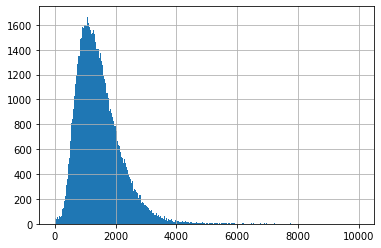

In [162]:
test1.Total_Population.hist(bins=400,range=(0,10000))